In [1]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.model_selection

from recommend.utils import PROJ_ROOT
from recommend.cf_recommenders import CFBaseline, CFGradFactor

In [2]:
ratings = pd.read_pickle(f"{PROJ_ROOT}/data/ratings.pkl")

In [3]:
ratings.shape

(2797751, 5)

In [4]:
def filter_ratings(ratings: pd.DataFrame, min_user_ratings: int, min_movie_ratings: int) -> pd.DataFrame:
    ratings = ratings.dropna()

    user_rating_count = ratings.groupby("username").size()
    worthy_users = set(user_rating_count[user_rating_count >= min_user_ratings].index)
    ratings = ratings.loc[ratings.username.isin(worthy_users)]

    movie_rating_count = ratings.groupby("movie_id").size()
    worthy_movies = set(movie_rating_count[movie_rating_count >= min_movie_ratings].index)
    ratings = ratings.loc[ratings.movie_id.isin(worthy_movies)]
    
    return ratings

In [5]:
ratings = filter_ratings(ratings, 10, 10)

In [6]:
ratings.shape

(2722362, 5)

In [7]:
ratings_train, ratings_test = sklearn.model_selection.train_test_split(
    ratings,
    test_size=0.1,
    shuffle=True,
    random_state=0,
)

ratings_train, ratings_valid = sklearn.model_selection.train_test_split(
    ratings_train,
    test_size=0.1,
    shuffle=True,
    random_state=0,
)

In [8]:
ratings_train.head()

,username,movie_id,stars,date,comment
328863,pepo,2596-osm-a-pul,1.0,2018-04-24,"Súhlasím, že 8 1/2 je umelecký film. Je totiž..."
1601217,Melly.pro,224137-hvezdny-prach,5.0,2008-01-18,"Tak nejsem si úplně jistej, co o tom říct, pr..."
1369474,GOREGASM,223564-kazatel,2.0,2016-01-31,Béčkové vody zakalené do digitálního apokalyp...
499592,Ernie_13,308635-zpatky-ve-hre,3.0,2014-03-07,"No je to tých 70%....hrozná réžia, hrozný sce..."
2322162,Khumbac,71194-walker-texas-ranger,4.0,2012-07-14,"Z nostalgie, z recese, z úcty ke komedii dává..."


In [9]:
baseline = CFBaseline()
baseline.train(ratings_train)

In [10]:
import math
num_features = 10

recommender = CFGradFactor(
    all_movies=ratings.movie_id.unique().tolist(),
    all_users=ratings.username.unique().tolist(),
    num_features=num_features,
    init_scale=0.05,
    init_shift=math.sqrt(0.5/num_features),
)


epoch 0:   0%|          | 0/8614 [00:00<?, ?it/s]

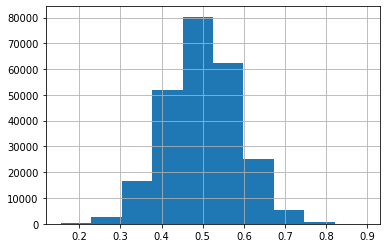

epoch 0:   0%|          | 5/8614 [00:22<7:59:04,  3.34s/it] 

train metrics:      {'mse': 0.11332612045280371, 'mae_stars': 1.436988790249277}
validation metrics: {'mse': 0.11283333176486428, 'mae_stars': 1.4350158385543583}


epoch 1:  45%|████▍     | 3874/8614 [00:55<00:40, 117.44it/s]

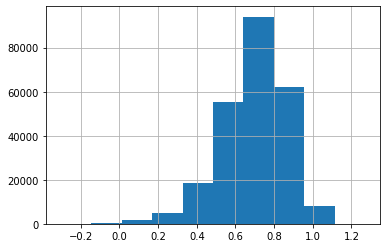

epoch 1:  45%|████▌     | 3901/8614 [00:57<14:59,  5.24it/s] 

train metrics:      {'mse': 0.039524310305403515, 'mae_stars': 0.7656862768101543}
validation metrics: {'mse': 0.04068890073198615, 'mae_stars': 0.7768135964870453}


epoch 2:  90%|█████████ | 7768/8614 [00:53<00:01, 714.47it/s]

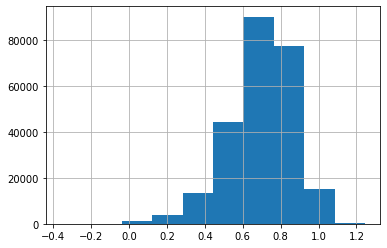

epoch 2:  91%|█████████ | 7840/8614 [01:06<00:39, 19.43it/s] 

train metrics:      {'mse': 0.03947920338610393, 'mae_stars': 0.7642735731253295}
validation metrics: {'mse': 0.040720535245858176, 'mae_stars': 0.775645926065883}


epoch 3: 100%|██████████| 8614/8614 [00:55<00:00, 154.66it/s]


In [11]:
recommender.train(
    ratings_train,
    ratings_valid,
    learning_rate=0.001,
    batch_size=256,
    early_stopping_threshold=0.02,
    max_epochs=4,
    return_to_best=False,
    path_to_save=f"{PROJ_ROOT}/models/cf_recommender_tiny_{num_features}.pt",
)

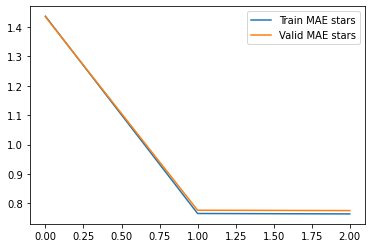

In [12]:
try:
    pd.DataFrame({
        "Train MAE stars": pd.DataFrame(recommender.trainer.metrics_train).mae_stars,
        "Valid MAE stars": pd.DataFrame(recommender.trainer.metrics_valid).mae_stars,
    }).plot()
except:
    pass

<AxesSubplot:>

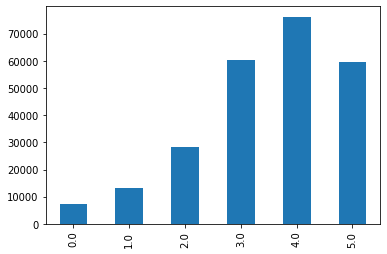

In [13]:
ratings_valid.stars.round().value_counts().sort_index().plot.bar()

<AxesSubplot:>

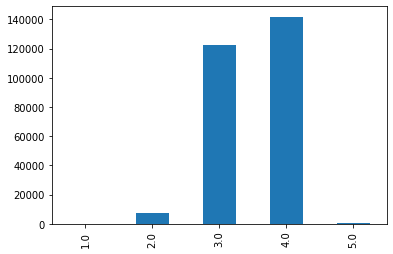

In [14]:
pd.Series(baseline.predict_ratings(ratings_test.movie_id, ratings_test.username)).round().value_counts().sort_index().plot.bar()

<AxesSubplot:>

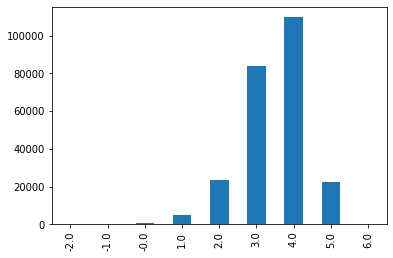

In [15]:
pd.Series(recommender.predict_ratings(ratings_valid.movie_id, ratings_valid.username)).round().value_counts().sort_index().plot.bar()

In [16]:
df_movies = pd.read_pickle(f"{PROJ_ROOT}/data/movies.pkl")
df_movies.head()

,title,description,kind,genres,countries,year,length,poster,foreign_titles,creators
movie_id,,,,,,,,,,
230421-houbicky,Houbičky,"Partička amerických teenagerů, která si vyrazi...",movie,"[Horor, Thriller]","[Irsko, Velká Británie, Dánsko]",2007,84 min,//image.pmgstatic.com/cache/resized/w420/files...,{'Irsko': 'Shrooms'},"{'Režie': [('/tvurce/4690-paddy-breathnach/', ..."
10789-prvni-liga,První liga,V nejvyšší lize získávají hráči baseballu boha...,movie,"[Komedie, Sportovní]",[USA],1989,107 min,//image.pmgstatic.com/cache/resized/w420/files...,"{'USA': 'Major League', 'Slovensko': 'Prvá liga'}","{'Režie': [('/tvurce/4010-david-s-ward/', 'Dav..."
235032-yes-man,Yes Man,"Carl Allen je zatrpklý bankovní úředník, který...",movie,"[Komedie, Romantický]",[USA],2008,100 min,//image.pmgstatic.com/files/images/film/poster...,"{'Austrálie': 'Yes Man', 'Kanada': 'Yes Man', ...","{'Režie': [('/tvurce/8883-peyton-reed/', 'Peyt..."
234754-chlapec-v-pruhovanem-pyzamu,Chlapec v pruhovaném pyžamu,Osmiletý Bruno žije se svojí rodinou v Berlíně...,movie,"[Drama, Válečný]","[Velká Británie, USA]",2008,94 min,//image.pmgstatic.com/files/images/film/poster...,"{'USA': 'The Boy in the Striped Pajamas', 'ang...","{'Režie': [('/tvurce/6600-mark-herman/', 'Mark..."
301717-nejvetsi-showman,Největší showman,Hugh Jackman vévodí hvězdnému obsazení odvážné...,movie,"[Muzikál, Životopisný, Drama]",[USA],2017,105 min,//image.pmgstatic.com/cache/resized/w420/files...,"{'USA': 'The Greatest Showman', 'Slovensko': '...","{'Režie': [('/tvurce/78497-michael-gracey/', '..."


In [17]:
from sklearn.metrics import mean_absolute_error as mae


In [18]:
glob_avg = ratings_train.stars.mean()

for part, name in  [(ratings_train, "train"), (ratings_valid, "valid"), (ratings_test, "test")]:

    print(name)


    baseline_preds = baseline.predict_ratings(part.movie_id, part.username)
    model_preds = recommender.predict_ratings(part.movie_id, part.username)
    glob_mean = part.stars.mean()

    print("  Mean absolute error in stars")
    print(f"  global avg {glob_avg:<0.2f}:     ", mae(part.stars, np.ones_like(part.stars) * glob_avg))
    print("  baseline:            ", mae(part.stars, baseline_preds))
    print("  baseline + round:    ", mae(part.stars, baseline_preds.round()))
    print("  model:               ", mae(part.stars, model_preds))
    print("  model + round:       ", mae(part.stars, model_preds.round()))

train
  Mean absolute error in stars
  global avg 3.48:      1.059991164859358
  baseline:             0.8469894055543328
  baseline + round:     0.8029428890686732
  model:                0.7654886457826121
  model + round:        0.7279385355483078
valid
  Mean absolute error in stars
  global avg 3.48:      1.058233041209562
  baseline:             0.8516083842821427
  baseline + round:     0.8074428703783064
  model:                0.775984544215208
  model + round:        0.7383118446776293
test
  Mean absolute error in stars
  global avg 3.48:      1.0586163514514702
  baseline:             0.853504197963633
  baseline + round:     0.810161734077293
  model:                0.7790968330102072
  model + round:        0.742661724894118


In [19]:
df_movies.loc[recommender.recommend_from_movie(
    "393331-avengers-infinity-war"
    #"234460-skyfall"
    #"110420-mission-impossible-iii"
    #"5992-marecku-podejte-mi-pero"
    #"19838-doba-ledova"
    #"301401-rivalove"
)]["genres"]

movie_id
296639-stvanec                                                                  [Thriller]
294672-g-i-joe-2-odveta                             [Akční, Dobrodružný, Sci-Fi, Thriller]
16552-spinavej-joe                          [Komedie, Dobrodružný, Romantický, Road movie]
31653-tri-barvy-bila                                                      [Komedie, Drama]
188003-hop-nebo-trop                                       [Komedie, Rodinný, Dobrodružný]
8750-vitezove-a-porazeni                                                [Drama, Sportovní]
228218-andele-slunce                                                               [Drama]
8381-utek-z-alcatrazu                                                    [Drama, Thriller]
91936-zamek-v-oblacich                       [Animovaný, Dobrodružný, Fantasy, Romantický]
44-tajemna-vrazda-na-manhattanu                              [Komedie, Mysteriózní, Krimi]
13130-orka-zabijak                                   [Dobrodružný, Drama, Thrille